# Imports

In [2]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, "lib/")
from utils.preprocess_sample import preprocess_sample
from utils.collate_custom import collate_custom
from utils.utils import to_cuda_variable
from utils.json_dataset_evaluator import evaluate_boxes,evaluate_masks
from model.detector import detector
import utils.result_utils as result_utils
import utils.vis as vis_utils
import skimage.io as io
from utils.blob import prep_im_for_blob
import utils.dummy_datasets as dummy_datasets

from utils.selective_search import selective_search # needed for proposal extraction in Fast RCNN
from PIL import Image

torch_ver = torch.__version__[:3]

# Parameters

In [3]:
# Pretrained model
arch='resnet50'
mapping_file = 'files/mapping_files/resnet50_mapping.npy'

# COCO minival2014 dataset path
coco_ann_file='datasets/data/coco/annotations/instances_minival2014.json'
img_dir='datasets/data/coco/val2014'

# model type
model_type='mask' # change here

if model_type=='mask':
    # https://s3-us-west-2.amazonaws.com/detectron/35858828/12_2017_baselines/e2e_mask_rcnn_R-50-C4_2x.yaml.01_46_47.HBThTerB/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl
    pretrained_model_file = 'files/trained_models/mask/model_final.pkl'
    use_rpn_head = True
    use_mask_head = True
elif model_type=='faster':
    # https://s3-us-west-2.amazonaws.com/detectron/35857281/12_2017_baselines/e2e_faster_rcnn_R-50-C4_2x.yaml.01_34_56.ScPH0Z4r/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl
    pretrained_model_file = 'files/trained_models/faster/model_final.pkl'
    use_rpn_head = True
    use_mask_head = False
elif model_type=='fast':
    # https://s3-us-west-2.amazonaws.com/detectron/36224046/12_2017_baselines/fast_rcnn_R-50-C4_2x.yaml.08_22_57.XFxNqEnL/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl
    pretrained_model_file = 'files/trained_models/fast/model_final.pkl'
    use_rpn_head = False
    use_mask_head = False

# Load image

In [4]:
image_fn = 'demo/33823288584_1d21cf0a26_k.jpg'

# Load image
image = io.imread(image_fn)
if len(image.shape) == 2: # convert grayscale to RGB
    image = np.repeat(np.expand_dims(image,2), 3, axis=2)
orig_im_size = image.shape
# Preprocess image
im_list, im_scales = prep_im_for_blob(image)
# Build sample
sample = {}
sample['image'] = torch.FloatTensor(im_list[0]).permute(2,0,1).unsqueeze(0)
sample['scaling_factors'] = torch.FloatTensor([im_scales[0]])
sample['original_im_size'] = torch.FloatTensor(orig_im_size)
# Extract proposals
if model_type=='fast':
    # extract proposals using selective search (xmin,ymin,xmax,ymax format)
    rects = selective_search(pil_image=Image.fromarray(image),quality='f')
    sample['proposal_coords']=torch.FloatTensor(preprocess_sample().remove_dup_prop(rects)[0])*im_scales[0]
else:
    sample['proposal_coords']=torch.FloatTensor([-1]) # dummy value
# Convert to cuda variable
sample = to_cuda_variable(sample)

# Create detector model

In [4]:
model = detector(arch=arch,
                 detector_pkl_file=pretrained_model_file,
                 mapping_file=mapping_file,
                 use_rpn_head = use_rpn_head,
                 use_mask_head = use_mask_head)
model = model.cuda()

loading pretrained weights


# Evaluate

In [5]:
def eval_model(sample):
    class_scores,bbox_deltas,rois,img_features=model(sample['image'],
                                                     sample['proposal_coords'],
                                                     scaling_factor=sample['scaling_factors'].cpu().data.numpy().item())   
    return class_scores,bbox_deltas,rois,img_features

In [6]:
if torch_ver=="0.4":
    with torch.no_grad():
        class_scores,bbox_deltas,rois,img_features=eval_model(sample)
else:
    class_scores,bbox_deltas,rois,img_features=eval_model(sample)

# postprocess output:
# - convert coordinates back to original image size, 
# - treshold proposals based on score,
# - do NMS.
scores_final, boxes_final, boxes_per_class = result_utils.postprocess_output(rois,
                                                                sample['scaling_factors'],
                                                                sample['original_im_size'],
                                                                class_scores,
                                                                bbox_deltas)

if model_type=='mask':
    # compute masks
    boxes_final_th = Variable(torch.cuda.FloatTensor(boxes_final))*sample['scaling_factors']
    masks=model.mask_head(img_features,boxes_final_th)
    # postprocess mask output:
    h_orig = int(sample['original_im_size'].squeeze()[0].data.cpu().numpy().item())
    w_orig = int(sample['original_im_size'].squeeze()[1].data.cpu().numpy().item())
    cls_segms = result_utils.segm_results(boxes_per_class, masks.cpu().data.numpy(), boxes_final, h_orig, w_orig)
else:
    cls_segms = None

print('Done!')

Done!


# Visualize

result saved to demo/output/33823288584_1d21cf0a26_k.jpg.pdf


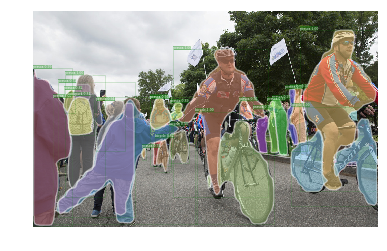

In [7]:
output_dir = 'demo/output/'
vis_utils.vis_one_image(
    image,  # BGR -> RGB for visualization
    image_fn,
    output_dir,
    boxes_per_class,
    cls_segms,
    None,
    dataset=dummy_datasets.get_coco_dataset(),
    box_alpha=0.3,
    show_class=True,
    thresh=0.7,
    kp_thresh=2,
    show=True
)